# Parameter Inference

EOS can infer parameters based on a database of experimental or theoretical constraints and its built-in observables.
The examples in this notebook illustrate how to find a specific constraint from the list of all built-in observables,
include them in an analysis file,
and infer mean value and standard deviation of a list of parameters through sampling methods.

In [1]:
import eos
import numpy as np

## Listing the built-in Constraints

The full list of built-in constraints for the most-recent EOS release is available online [here](https://eos.github.io/doc/reference/constraints). You can also show this list using the [eos.Constraints](../reference/python.rst#eos.Constraints) class.  Searching for a specific constraint is possible by filtering for specific strings in the constraint name’s *prefix*, *name*, or *suffix* parts. The following example only shows constraints that contain a `'->D'` in the prefix part:

In [2]:
eos.Constraints(prefix='B^0->D^+')

qualified name,observables,type,reference
B^0->D^+e^-nu::BRs@Belle:2015A,... B->Dlnu::BR,MultivariateGaussian(Covariance),Belle:2015A
B^0->D^+l^-nu::KinematicalDistribution[w]@Belle:2015A,"... B->Dlnu::P(w_min,w_max)",MultivariateGaussian(Covariance),Belle:2015A
B^0->D^+mu^-nu::BRs@Belle:2015A,... B->Dlnu::BR,MultivariateGaussian(Covariance),Belle:2015A


## Visualizing the built-in Constraints

For what follows we will use the two experimental constraints ``B^0->D^+e^-nu::BRs@Belle:2015A``
and ``B^0->D^+mu^-nu::BRs@Belle:2015A``, to infer the CKM matrix element $|V_{cb}|$. We can readily
display these two constraints, along with the default theory prediction (without any uncertainties),
using the following code:

Unit Unrecognized unit 'GeV^{-2}' encountered


Unit Unrecognized unit 'GeV^{-2}' encountered


   plotting EOS observable "B->Dlnu::dBR/dq2;l=e,q=d"


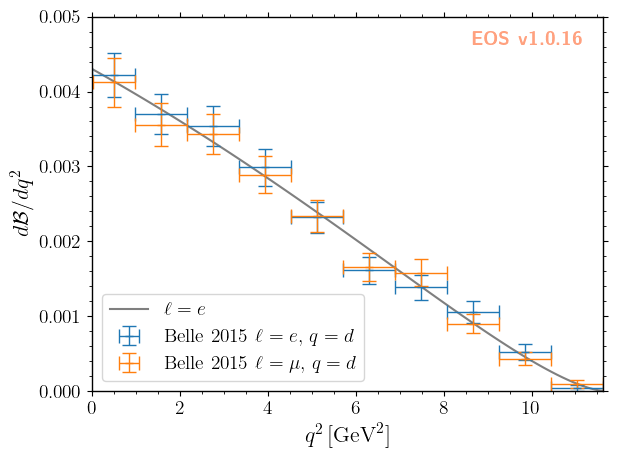

In [3]:
plot_args = {
    'plot': {
        'x': { 'label': r'$q^2$', 'unit': r'$\textnormal{GeV}^2$', 'range': [0.0, 11.63] },
        'y': { 'label': r'$d\mathcal{B}/dq^2$',                    'range': [0.0,  5e-3] },
        'legend': { 'location': 'lower left' }
    },
    'contents': [
        {
            'label': r'$\ell=e$',
            'type': 'observable',
            'observable': 'B->Dlnu::dBR/dq2;l=e,q=d',
            'variable': 'q2',
            'color': 'black',
            'range': [0.02, 11.63],
        },
        {
            'label': r'Belle 2015 $\ell=e,\, q=d$',
            'type': 'constraint',
            'color': 'C0',
            'constraints': 'B^0->D^+e^-nu::BRs@Belle:2015A',
            'observable': 'B->Dlnu::BR',
            'variable': 'q2',
            'rescale-by-width': True
        },
        {
            'label': r'Belle 2015 $\ell=\mu,\,q=d$',
            'type': 'constraint',
            'color': 'C1',
            'constraints': 'B^0->D^+mu^-nu::BRs@Belle:2015A',
            'observable': 'B->Dlnu::BR',
            'variable': 'q2',
            'rescale-by-width': True
        },
    ]
}
_ = eos.plot.Plotter(plot_args).plot()

## Defining the analysis

To define our statistical analysis for the inference of $|V_{cb}|$ from measurements
of the $\bar{B}\to D\ell^-\bar\nu$ branching ratios, we must decide how to parametrize
the hadronic form factors that emerge in semileptonic $\bar{B}\to D$ transitions and
how to constraint them. On top of the theoretical constraints and form factor coefficient priors as in `predictions.yaml`, we must add a prior for varying the CKM element and experimental constraints from which to extract it.
We only vary the absolute value of the CKM element `CKM::abs(V_cb)`, as the complex phase of the CKM element `CKM::arg(V_cb)` is not accessible from $b\to c \ell \bar \nu$.
In order to use this parametrization of the CKM elements, we must use the model `CKM` in the analysis.

These additions to the likelihood and priors, seen in the analysis file `inference.yaml`, look like
```yaml
priors:
  - name: CKM
    descriptions:
      - { parameter: 'CKM::abs(V_cb)',           min:  38e-3, max:  45e-3 , type: 'uniform' }

  - name: FF
    # as in both predictions.yaml and inference.yaml

likelihoods:
  - name: B-to-D-l-nu
    constraints:
      - 'B^0->D^+e^-nu::BRs@Belle:2015A;form-factors=BSZ2015'
      - 'B^0->D^+mu^-nu::BRs@Belle:2015A;form-factors=BSZ2015'

  - name: FF-LQCD
    # as in both predictions.yaml and inference.yaml
```



## Sampling from the posterior

EOS provides the means to draw and store Monte Carlo samples for a prior PDF $P_0(\vec\vartheta)$, a posterior PDF $P(\vec\vartheta|\text{data})$, and predictive distributions using [eos.tasks.sample_nested](../reference/python.rst#eos.sample_nested). We store this data within a hierarchy of directories below a "base directory". For the purpose of the following examples, we set this base directory to ``./inference-data``, stored in a convenient global variable.

In [4]:
EOS_BASE_DIRECTORY='./inference-data'

In [5]:
eos.tasks.sample_nested('inference.yaml', 'CKM', base_directory=EOS_BASE_DIRECTORY, nlive=250, dlogz=0.5, seed=42)

Accordion(children=(Output(layout=Layout(height='200px', overflow='auto')),), titles=('CKM/nested',))

## Inferring the $|V_{cb}|$ parameter

The distribution of the parameter samples, here using $|V_{cb}|$ as an example, can be inspected using regular histograms or a smooth histogram based on a kernel density estimate (KDE). The samples are automatically processed, when specifying the ``data-file`` directory and the ``variable`` as histogram plotting arguments. For the KDE, the parameter ``bandwidth`` regulates the smoothing. EOS applies a relative bandwidth factor with respect to SciPy's best bandwidth estimate, i.e., specifying `'bandwidth': 2` doubles SciPy's estimate for the bandwidth.

   plotting histogram from "./inference-data/CKM/samples"


   prefix = samples


   plotting KDE for "./inference-data/CKM/samples"


   prefix = samples


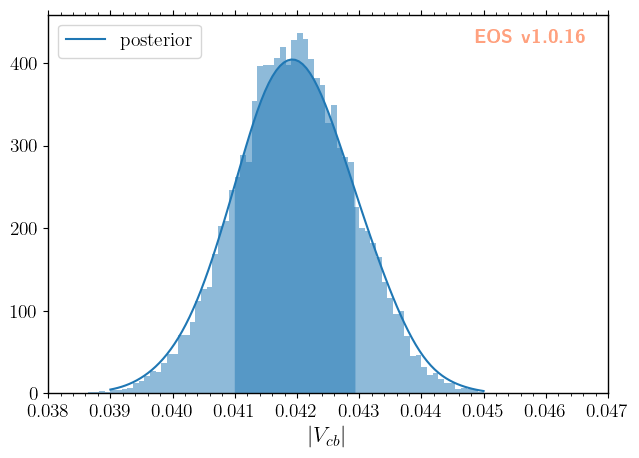

In [6]:
plot_args = {
    'plot': {
        'x': { 'label': r'$|V_{cb}|$', 'range': [38e-3, 47e-3] },
        'legend': { 'location': 'upper left' }
    },
    'contents': [
        {
            'type': 'histogram',
            'variable': 'CKM::abs(V_cb)',
            'data-file': EOS_BASE_DIRECTORY+'/CKM/samples'
        },
        {
            'type': 'kde', 'color': 'C0', 'label': 'posterior', 'bandwidth': 2,
            'range': [39e-3, 45e-3],
            'variable': 'CKM::abs(V_cb)',
            'data-file': EOS_BASE_DIRECTORY+'/CKM/samples'
        }
    ]
}
_ = eos.plot.Plotter(plot_args).plot()

To extract further information from the parameter samples, we can load the sample values using [eos.data.ImportanceSamples](../reference/python.rst#eos.data.ImportanceSamples):

In [7]:
parameter_samples = eos.data.ImportanceSamples(EOS_BASE_DIRECTORY+'/CKM/samples')

We can compute the mean value and its standard deviation using ``numpy`` methods, including the sample ``weights``.

In [8]:
mean = np.average(parameter_samples.samples[:,0], weights = parameter_samples.weights)
std = np.sqrt(np.average((parameter_samples.samples[:,0]-mean)**2, weights = parameter_samples.weights))

print(f'$|V_{{cb}}|$ = {mean:.4f} +/- {std:.4f}')

$|V_{cb}|$ = 0.0420 +/- 0.0009


We can also illustrate the correlation between $|V_{cb}|$ and any form factor parameter. Here, we use the normalization of the form factors at $q^2 = 0$ as an example. The ``data`` passed to the plotter consists of the 2d parameter samples and the corresponding sample weights.
Contours of equal probability at the $68\%$ and $95\%$ levels can be generated using a KDE as follows:

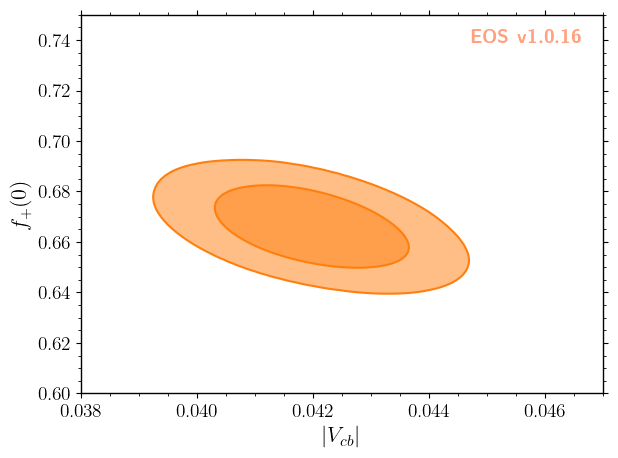

In [9]:
plot_args = {
    'plot': {
        'x': { 'label': r'$|V_{cb}|$', 'range': [38e-3, 47e-3] },
        'y': { 'label': r'$f_+(0)$',   'range': [0.6, 0.75] },
    },
    'contents': [
        {
            'type': 'kde2D', 'color': 'C1', 'label': 'posterior',
            'levels': [68, 95], 'contours': ['lines','areas'], 'bandwidth':3,
            'data': {
                'samples': parameter_samples.samples[:, (0,1)],
                'weights': parameter_samples.weights
            }
        }
    ]
}
_ = eos.plot.Plotter(plot_args).plot()

Here the `bandwidth` parameter takes the same role as in the 1D histogram.

## Aside: validating the posterior

As an additional step we can visualize the resulting theory prediction (with uncertainties), as was done in the beginning of this notebook. For further details, you can consult the ``predictions.ipynb`` notebook.

In [10]:
eos.predict_observables('inference.yaml','CKM','B-to-D-e-nu', base_directory=EOS_BASE_DIRECTORY)

Accordion(children=(Output(layout=Layout(height='200px', overflow='auto')),), titles=('CKM/pred-B-to-D-e-nu',)…

   plotting uncertainty propagation from "./inference-data/CKM/pred-B-to-D-e-nu"


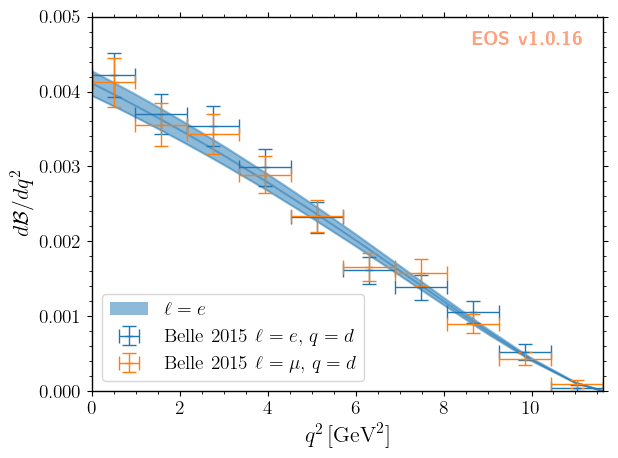

In [11]:
plot_args = {
    'plot': {
        'x': { 'label': r'$q^2$', 'unit': r'$\textnormal{GeV}^2$', 'range': [0.0, 11.63] },
        'y': { 'label': r'$d\mathcal{B}/dq^2$',                    'range': [0.0,  5e-3] },
        'legend': { 'location': 'lower left' }
    },
    'contents': [
        {
          'label': r'$\ell=e$', 'type': 'uncertainty', 'range': [3.0e-7, 11.60],
          'data-file': EOS_BASE_DIRECTORY+'/CKM/pred-B-to-D-e-nu',
        },
        {
            'label': r'Belle 2015 $\ell=e,\, q=d$',
            'type': 'constraint',
            'color': 'C0',
            'constraints': 'B^0->D^+e^-nu::BRs@Belle:2015A',
            'observable': 'B->Dlnu::BR',
            'variable': 'q2',
            'rescale-by-width': True
        },
        {
            'label': r'Belle 2015 $\ell=\mu,\,q=d$',
            'type': 'constraint',
            'color': 'C1',
            'constraints': 'B^0->D^+mu^-nu::BRs@Belle:2015A',
            'observable': 'B->Dlnu::BR',
            'variable': 'q2',
            'rescale-by-width': True
        },
    ]
}
_ = eos.plot.Plotter(plot_args).plot()